## USER OF LINE ANGLE AND LENGTH PREDICTOR V1

In [25]:
import math
import scipy as sc
import pickle
import matplotlib.pyplot as plt
import numpy as np
from math import atan2,degrees
from math import sqrt
from math import fabs
from scipy import misc as ms

### Utility functions  for image feature extractions

In [26]:
'''
For rotating  image 
'''
def RotateImage(image, dim):
    
    new_image = np.zeros((dim, dim), dtype=np.uint8)
    new_image[:,:] = 255 
     
    # Rotate
    for row in range(0,100): # Visit all collumns
        for col in range(0,100): 
            new_image[ dim - row -1,col] = image[row,  col] 

    # Copy back 
    for row in range(0,100): # Visit all collumns
        for col in range(0,100): 
             image[row,  col] = new_image[row, col]

In [27]:
'''
For projecting the image on the y axis
'''
def Get_Y_Shadow(image):
    dim = 100  
    #y_shadow =  np.zeros(dim, dtype=np.uint8) 
    y_shadow =  np.full(dim,  255) 
    index= 0
    
    # Start from left col (x=0) to last col (x= 99
    for col in range(0,100): # Visit all collumns
        for row in range(0,100): 
            gray = image[row,  col]
            if  gray == 0 : # Look for non-white pixels
                # Project on y-axis
                if y_shadow[row]== 255: # Move if not was already plotted
                    index = index + 1  
                # Project on y-axis
                y_shadow[row]= col # y_shadow[row] + 1 
                 
    # ADJUSTED index needs to be less one
    index = index -1
    
    #print(index)
    return y_shadow,index
                    

In [28]:
'''
For projecting the image on the x axis
'''
def Get_X_Shadow(image):
    dim = 100  
    #x_shadow =  np.zeros(dim, dtype=np.uint8) 
    x_shadow =  np.full(dim,  255) 
        
    index= 0
    
    # Start from top row (y=99) to last row (y= 99
    for row in range(0,100): # Visit all collumns
        for col in range(0,100): 
            gray = image[row,  col]
            if  gray == 0 : # Look for non-white pixels
                
                if x_shadow[col]== 255: # Move if not was already plotted
                    index = index + 1  
                # Project on x-axis
                x_shadow[col]= dim - 1- row #x_shadow[col] + 1 
     
    #print(index)
    
    #print(x_shadow)
    # ADJUSTED index needs to be less one
    index = index -1
    return x_shadow,index
                    

In [29]:
def getFirstFromLeft(a, dim):
    for i in range(0,dim):
        if   a[i] != 255 :
            #print('From left: {}:{}'.format( i,a[i] ))
            return a[i]  

In [30]:
def getFirstFromRight(a, dim):
    for i in range(dim-1,-1,-1):
        #print(i)
        if   a[i] != 255 :
            #print('From right: {}:{}'.format( i,a[i] ))
            return a[i]  

In [31]:
def CheckIfDescends ( a, dim):
    left = getFirstFromLeft(a, dim)   
    right = getFirstFromRight(a, dim)
    
    #print("left is {}".format(left))
    #print("right is {}".format(right))
    
    return right < left

In [32]:
'''
For reducing the features, we condense the columns into one column
and the rows in one row. So will reduce image to two features  
    - yShadow
    - xShadow
'''
def ExtractImageFeatures( image, dim):  
 
    yShadow,dy = Get_Y_Shadow(image) 
    xShadow,dx = Get_X_Shadow(image)
 
    lineDescends = CheckIfDescends(xShadow,dim)
    if lineDescends: 
        dy = -1*dy
         
    return dx,dy
    

In [33]:
'''
For reducing the features, we condense the columns into one column
and the rows in one row. So will reduce image to two features  
    - yShadow
    - xShadow
'''
def ExtractImageFeaturesForLengthPredictor( image, dim):  
 
    yShadow,dy = Get_Y_Shadow(image) 
    xShadow,dx = Get_X_Shadow(image)
 
    # No need to check for descending lines
    # as is trained for only positive dx values!
    
    #print("           ==> Line prediction using dx={} and dy={}".format(dx,dy))
    return dx,dy

### Additional utility functions 

In [34]:
def ConvertClassCodeToLabel(code):
    if code == 0.0:
        return 'HORIZONTAL'
    if code == 1.0:
        return 'VERTICAL'
    if code == 2.0:
        return 'ASCENDING'
    if code == 3.0:
        return 'DESCENDING'

In [35]:
'''
For finding the distance between points
'''
def Distance(p1,p2):
    
    x1 = p1[0]
    y1 = p1[1]
    
    x2 = p2[0]
    y2 = p2[1]
    
    dx = x1-x2
    dy = y1-y2
    
    d= math.sqrt(  (dx*dx) + (dy*dy) )
    return d
    
 

In [36]:
'''
For finding the angle of line between two points
Assume origin of coordinate system a left bottom
'''
# Make sure left hand point comes first!
 
def Angle2(p1, p2):
    x1 = p1[0]
    y1 = p1[1]
    
    x2 = p2[0]
    y2 = p2[1]
    
    # If incoming points already sorted on left hand point first
    #xDiff = p2[0] - p1[0]
    #yDiff = p2[1] - p1[1]
    
    # IF NOT VERTICAL
    if( x1 != x2):
        #Check if first point is left hand  
        if( x1> x2):# Not left hand so swap
            # Swap P1 and P2
            tx=x1
            ty=y1
            
            x1=x2
            y1=y2
            
            x2=tx
            y2=ty
    else: # Verical so check lowest point first
         if( y1> y2):# Not left hand so swap
            # Swap P1 and P2
            tx=x1
            ty=y1
            
            x1=x2
            y1=y2
            
            x2=tx
            y2=ty   
    
    xDiff = x2 - x1
    yDiff = y2 - y1
    
    ang = math.degrees(atan2(yDiff, xDiff)) # + 90 
   
     
    # Enable If we want vertical to be recorded as d
    # DOWN = -90 rather than UP = 90
    #if ang == 90:
    #     ang = -90
    
    return ang 



In [37]:
'''
For finding the angle of line between two points
Assume origin of coordinate system a left bottom
'''
# Make sure left hand point comes first!
 
def Angle(p1, p2):
    x1 = p1[0]
    y1 = p1[1]
    
    x2 = p2[0]
    y2 = p2[1]
    
    # Make sure left hand point first
    xDiff = p2[0] - p1[0]
    yDiff = p2[1] - p1[1]
    
    ang = math.degrees(atan2(yDiff, xDiff)) 
    return ang

In [38]:
p1= [0,0]
p2= [99,99]

l = Distance(p1,p2)
a = Angle(p1,p2)

print("lenght = {}".format(l))
print("angle = {}".format(a))

lenght = 140.0071426749364
angle = 45.0


In [39]:
def LoadImage(filename):#"test.bmp"
    image= sc.misc.imread(filename , flatten= 1)
    plt.imshow(image, cmap='gray') 
    return image

### Load the Model and X_Scaler - For Linear Regression - Angle predictor

In [40]:
# This model is trained on ascending lines only
def LoadModelAndScalerForAnglePrediction(): #ascending_angle_predictor
    X_scaler = pickle.load(open('./PICKLES/ascending_angle_predictor_X_scaler.pickle', 'rb'))
    model = pickle.load(open('./PICKLES/ascending_angle_predictor.pickle', 'rb'))
    
    return X_scaler,model


### Load the Model and X_Scaler - For Linear Regression - Length predictor


In [41]:
def LoadModelAndScalerForLengthPrediction(): 
    X_scaler = pickle.load(open('./PICKLES/length_predictor_X_scaler.pickle', 'rb'))
    model = pickle.load(open('./PICKLES/length_predictor.pickle', 'rb'))
    
    return X_scaler,model


### Load the Model and X_Scaler - For Logistic Regression - Angle Class predictor

In [42]:
# load model in deployment
def LoadModelAndScalerForAngleClassification(): #ascending_angle_predictor
    X_scaler = pickle.load(open('./PICKLES/angle_classifier_X_scaler.pickle', 'rb'))
    model = pickle.load(open('./PICKLES/angle_classifier.pickle', 'rb'))
    
    return X_scaler, model 


### Load an image to predict angle of line

In [43]:
def LoadImage(filename):#"test.bmp"
    image= ms.imread(filename , flatten= 1)
    plt.imshow(image, cmap='gray') 
    return image

### Functions for user to make various prediction

In [44]:
def PredictAngleOfLine( image, dim, scaler, model):
    
    # We work with one image ( therefor we extract two features)
    noOfImages =1
    dim =100
    X = np.zeros((noOfImages, 2))

    # Extract and store image features 
    dx,dy = ExtractImageFeatures( image, dim) 
    X[0,0]= dx
    X[0,1]= dy
    
     
    
    # Predict the angle
    Z = scaler.transform(X)  
    y_pred = model.predict(Z)
    angle = y_pred[0]
    
    return angle
  

In [45]:
def PredictLengthOfLine( image, dim, scaler, model):
    
    # We work with one image ( therefor we extract two features)
    noOfImages =1
    dim =100
    X = np.zeros((noOfImages, 2))

    # Extract and store image features   
    dx,dy = ExtractImageFeaturesForLengthPredictor( image, dim) 
    
    X[0,0]= dx
    X[0,1]= dy
    
    # Predict the angle
    Z = scaler.transform(X)  
    y_pred = model.predict(Z)
    length = y_pred[0]
    
    return length

In [46]:
def PredictAngleClassOfLine( image, dim, scaler, model):
    
    # We work with one image ( we extract two features)
    noOfImages =1
    dim = 100
    df_X = np.zeros((noOfImages, 2)) 
    
    # Extract and store image features 
    dx,dy = ExtractImageFeatures( image, dim)  
    df_X[0,0]= dx
    df_X[0,1]= dy
 
    # Predict the Class
    df_Z = scaler.transform(df_X)   
    y_pred = model.predict(df_Z ) 
    angle_class_predict = y_pred[0]
    
    #print("dx= {}, dy= {}".format(dx,dy))  
    return angle_class_predict

    

## RUN MAIN PROGRAM


C:\Users\admin\Anaconda3\envs\mldds\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
C:\Users\admin\Anaconda3\envs\mldds\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


**************************************************
  PREDICTED VALUES                                
**************************************************
Class predicted =		 DESCENDING
Angle predicted=		 -45.79732875343496
Length predicted=		 9.834190323578284

**************************************************
  ACTUAL VALUES                                   
**************************************************
dx= 3, dy= -4
Actual angle=			-53.13010235415598
Actual lenght=			5.0


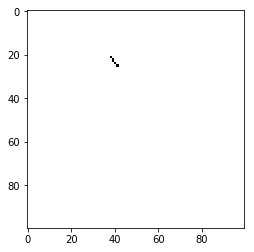

In [76]:
# ************************************************************
# The image you want to test
# You can open the bmp file in paint and then draw one 
# single line with pixel width of one
filename = "test.bmp"

#***********************************************************
# A folder with pre-prepared test cases
#filename = "./TEST/test1.bmp"

# If you want to see the actual values
PRINT_ACTUAL_VALUES = True

# Classes of angles
HOR= 0
VER= 1
ASC= 2
DSC= 3

# Load our 3 pre-trained models 
scalerAnglePredictor, modelAnglePredictor = LoadModelAndScalerForAnglePrediction() 
scalerAngleClassifier, modelAngleClassifier = LoadModelAndScalerForAngleClassification() 
scalerLengthPredictor, modelLengthPredictor = LoadModelAndScalerForLengthPrediction() 
 
# Load image (must be bmp with dimension 100*100)
dim = 100
image = LoadImage(filename) 
 

# Our predictions start here
print("**************************************************")
print("  PREDICTED VALUES                                ")
print("**************************************************")

# PREDICT CLASS **************************
class_code= PredictAngleClassOfLine( image, dim, scalerAngleClassifier, modelAngleClassifier)
#print('Angle Class Code predicted= {}'.format(class_code))
print('Class predicted =\t\t {}'.format(ConvertClassCodeToLabel(class_code)))

# PREDICT ANGLE **************************
if class_code == DSC:# If line is descending then rotate image first (as our model is trained for ascending lines)
    rot_image = LoadImage(filename) 
    RotateImage(rot_image, dim)
    #plt.imshow(image, cmap='gray') 
    angle= PredictAngleOfLine( rot_image, dim, scalerAnglePredictor, modelAnglePredictor)  * -1  
else:
    angle= PredictAngleOfLine( image, dim, scalerAnglePredictor, modelAnglePredictor)  

print('Angle predicted=\t\t {}'.format(angle))
  
# PREDICT LENGTH **************************
length = PredictLengthOfLine( image, dim, scalerLengthPredictor, modelLengthPredictor)
print('Length predicted=\t\t {}'.format(length))

# COUNTER CHECK THE PREDICTION WITH ACTUAL ANGLE AND LENGTH ****
# Based on image features dx and dy
if PRINT_ACTUAL_VALUES:
    print()
    print("**************************************************")
    print("  ACTUAL VALUES                                   ")
    print("**************************************************")
    #image = LoadImage(filename) 
    dx,dy = ExtractImageFeatures( image, dim)  
    print("dx= {}, dy= {}".format(dx,dy))  


    #  Tke note that (dx,dy) is used here as a displacement vector
    if dy<0:# If descending line
        p1 = [0,99]
        p2 = [0+dx,99 + dy]
    else:
        p1 = [0,0]
        p2 = [0+dx,0 + dy]

    l = Distance(p1,p2)
    a = Angle(p1,p2)

    print("Actual angle=\t\t\t{}".format(a))
    print("Actual lenght=\t\t\t{}".format(l))
    



